# **Traffic Sign Recognition (GTSRB)**

# **Imports**

In [21]:
# Core & Utils
import os, random, json, time, math
from collections import Counter, defaultdict
from datetime import datetime

# Data
import numpy as np
import pandas as pd
from PIL import Image

# Plotting
import matplotlib.pyplot as plt

# PyTorch
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms, models, utils

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

import itertools


# **Introduction, Motivation, and Problem Statement**


Traffic sign recognition plays a critical role in autonomous driving systems and advanced driver assistance systems (ADAS). Correctly identifying traffic signs in real time ensures that vehicles can respond appropriately to road rules, improving safety for both drivers and pedestrians.

In this project, we aim to develop and compare robust deep learning models capable of accurately classifying traffic signs from the German Traffic Sign Recognition Benchmark (GTSRB) dataset. The model should be able to generalize well under various lighting conditions, rotations, and augmentations.

The **problem statement** is:
> Build and evaluate deep learning models to classify images of traffic signs into their respective categories, optimizing for high accuracy and robustness against common variations in real-world driving conditions.

# **Setup**

In [ ]:
# Reproducibility
SEED = 43
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# GTRSB dataset paramametera and constants
NUM_CLASSES = 43           
IMG_SIZE_64 = (64, 64)     # Resize for MLP and CCN
IMG_SIZE_224 = (224, 224) # Resize for resnet
BATCH_SIZE = 16          

# Normalization
MEAN_GTSRB = [0.3403, 0.3121, 0.3214]
STD_GTSRB = [0.2724, 0.2608, 0.2669]

# ImageNet stats for pretrained ResNet
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]


Device: cuda


## **Data Source**

**Dataset:** German Traffic Sign Recognition Benchmark (**GTSRB**), introduced by Stallkamp et al. (2011).  
**Task:** Multi-class image classification with **43** traffic sign categories.  
**Official Splits:** ~**39,209** training images and ~**12,630** test images.

### How we accessed the data
- **API:** `torchvision.datasets.GTSRB`
  - `split='train'` or `split='test'`
  - Returns `(image, label)`

### Preprocessing used in this project
- **Resizing:**
  - **64×64** for Custom CNN and MLP
  - **224×224** for ResNet-50 (to match ImageNet pretraining)
- **Normalization:**
  - For 64×64 models (GTSRB stats): `mean=[0.3403, 0.3121, 0.3214]`, `std=[0.2724, 0.2608, 0.2669]`
  - For ResNet-50 (ImageNet stats): `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`
- **Augmentation (train only):** small rotations/affine shifts, translations, and color jitter.



# **Define Augmentations**

In [ ]:

# Data augmentation & preprocessing (train)

# Apply geometric + color augmentations to improve generalization,
# then convert to tensor and normalize with GTSRB statistics.
train_transform_64 = transforms.Compose([
    transforms.Resize(IMG_SIZE_64),
    transforms.RandomRotation(15), 
    transforms.RandomAffine(0, translate=(0.1, 0.1)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(), 
    transforms.Normalize(    
        mean=MEAN_GTSRB,
        std=STD_GTSRB
    ),
])

# Data augmentation & preprocessing (test and validation)

# only resize, tensor conversion, and normalization.
test_transform_64 = transforms.Compose([
    transforms.Resize(IMG_SIZE_64),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=MEAN_GTSRB,
        std=STD_GTSRB
    ),
])

# Data augmentation & preprocessing (train) for pretrained resnet

# Apply geometric + color augmentations to improve generalization,
# then convert to tensor and normalize with ImageNet statistics.
train_transform_resnet = transforms.Compose([
    transforms.Resize(IMG_SIZE_224), 
    transforms.RandomRotation(15), 
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(), 
    transforms.Normalize(   
        mean=MEAN_IMAGENET,
        std=STD_IMAGENET
    ),
])


# Data augmentation & preprocessing (test and validation) for pretrained resnet

# only resize, tensor conversion, and normalization.
test_transform_resnet = transforms.Compose([
    transforms.Resize(IMG_SIZE_224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=MEAN_IMAGENET,
        std=STD_IMAGENET
    ),
])

# **Get the GTSRB dataset from torchvision datasets**

In [6]:
# Load the GTSRB training training data
train_dataset_raw = torchvision.datasets.GTSRB(
    root='/content/dataset/',
    split='train',
    download=True
)
# Load the GTSRB testing data and apply the transforms form MLP and CNN
test_64 = torchvision.datasets.GTSRB(
    root='/content/dataset/',
    split='test',
    download=True,
    transform=test_transform_64
)
# Load the GTSRB testing data and apply the transforms for pretrained resnet
test_resnet = torchvision.datasets.GTSRB(
    root='/content/dataset/',
    split='test',
    download=True,
    transform=test_transform_resnet
)

# Get the total number of samples in the loaded training dataset
num_samples = len(train_dataset_raw)
print(f"Number of samples in the training data: {num_samples}")

100%|██████████| 187M/187M [00:06<00:00, 28.6MB/s]
100%|██████████| 89.0M/89.0M [00:03<00:00, 25.6MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 301kB/s]


Number of samples in the training data: 26640


## **Exploratory Analysis of the Data (GTSRB)**

### What the dataset looks like
- **Task:** multi-class traffic sign classification (single sign per image).
- **Dataset:** German Traffic Sign Recognition Benchmark (**GTSRB**).
- **Classes:** **43** distinct traffic signs (speed limits, warnings, prohibitions, etc.).
- **Size:** ~**51.8k** images in total (≈**39k** train, ≈**12.6k** test).
- **Images:** color RGB, varying original sizes and aspect ratios; backgrounds can include roads, sky, trees, cars.

### Class balance
- The dataset is **imbalanced**: some signs appear a lot, others are rare.
- We confirmed this by plotting a **class frequency bar chart**.
- To keep evaluation fair, we used a **stratified split** (train/val preserve class ratios), and **oversampled minority classes in train only**.

### Pre-processing
- **Resize** images to fit the model:
  - **64×64** for our **Custom CNN** and **MLP**.
  - **224×224** for **ResNet-50** (to match ImageNet pretraining).
- **Normalize** pixel values:
  - For 64×64 models: GTSRB mean/std → `mean=[0.3403, 0.3121, 0.3214]`, `std=[0.2724, 0.2608, 0.2669]`.
  - For ResNet-50: ImageNet mean/std → `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`.
- **Augmentation (train only):** random rotations, small translations/affine changes, and color jitter to mimic real driving conditions.
- **No leakage:** validation and test images are **never** oversampled or augmented beyond basic normalization.

### What we plotted during EDA
- **Class distribution** (bar chart) to see imbalance.
- **One sample per class** (grid) to understand visual variety.

### Why this dataset is challenging
- **Class imbalance:** rare signs can be hard to learn.
- **Fine-grained differences:** e.g., speed limit **“60” vs “80”** look very similar at a glance.
- **Real-world noise:** motion blur, glare, shadows, rain, faded paint, partial occlusion.
- **Scale & alignment:** signs can be **small** in the image or slightly rotated.
- **Background clutter:** trees, buildings, and vehicles can distract the model.

### How we handled the challenges
- **Stratified split** to keep class proportions stable across train/val.
- **Targeted augmentation** and **class-balanced oversampling** (train only) to help minority classes.
- **Robust evaluation:** report **accuracy + macro/micro precision/recall/F1**, show a **confusion matrix**, and inspect **misclassified examples** to understand errors.

### Takeaways from EDA
- The dataset’s **imbalance and fine-grained classes** are the main hurdles.
- Careful **pre-processing** (resize + correct normalization), **balanced training**, and **strong augmentations** are essential.
- Visual checks (class grids, confusion matrix, error gallery) give quick insight into which classes or conditions still need work.


# **Check Class Frequencies**

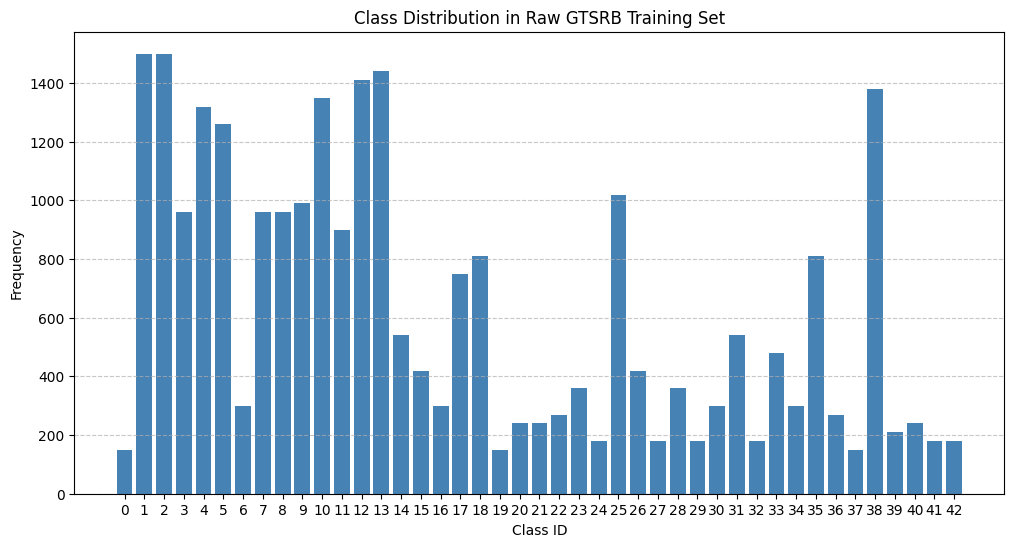

Minimum samples in a class: 150
Maximum samples in a class: 1500


In [8]:
# Labels for stratified split
labels_raw = [label for _, label in train_dataset_raw]

class_counts = Counter(labels_raw)

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue')
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.title("Class Distribution in Raw GTSRB Training Set")
plt.xticks(range(NUM_CLASSES))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Find the smallest and largest class sizes
min_samples = min(class_counts.values())  # Minimum number of samples in any class
max_samples = max(class_counts.values())  # Maximum number of samples in any class

# Display results
print(f"Minimum samples in a class: {min_samples}")
print(f"Maximum samples in a class: {max_samples}")

# **Split the raw data into training and validation**

In [9]:
# Stratified 80/20 split
train_idx, val_idx = train_test_split(
    np.arange(len(train_dataset_raw)),
    test_size=0.2,
    stratify=labels_raw,
    random_state=SEED
)

# Make subsets
train_base_raw = Subset(train_dataset_raw, train_idx)
val_base_raw   = Subset(train_dataset_raw, val_idx)

print(f"Stratified split, Train: {len(train_base_raw)}, Val: {len(val_base_raw)}")

Stratified split, Train: 21312, Val: 5328


# **Preview: one image per class**


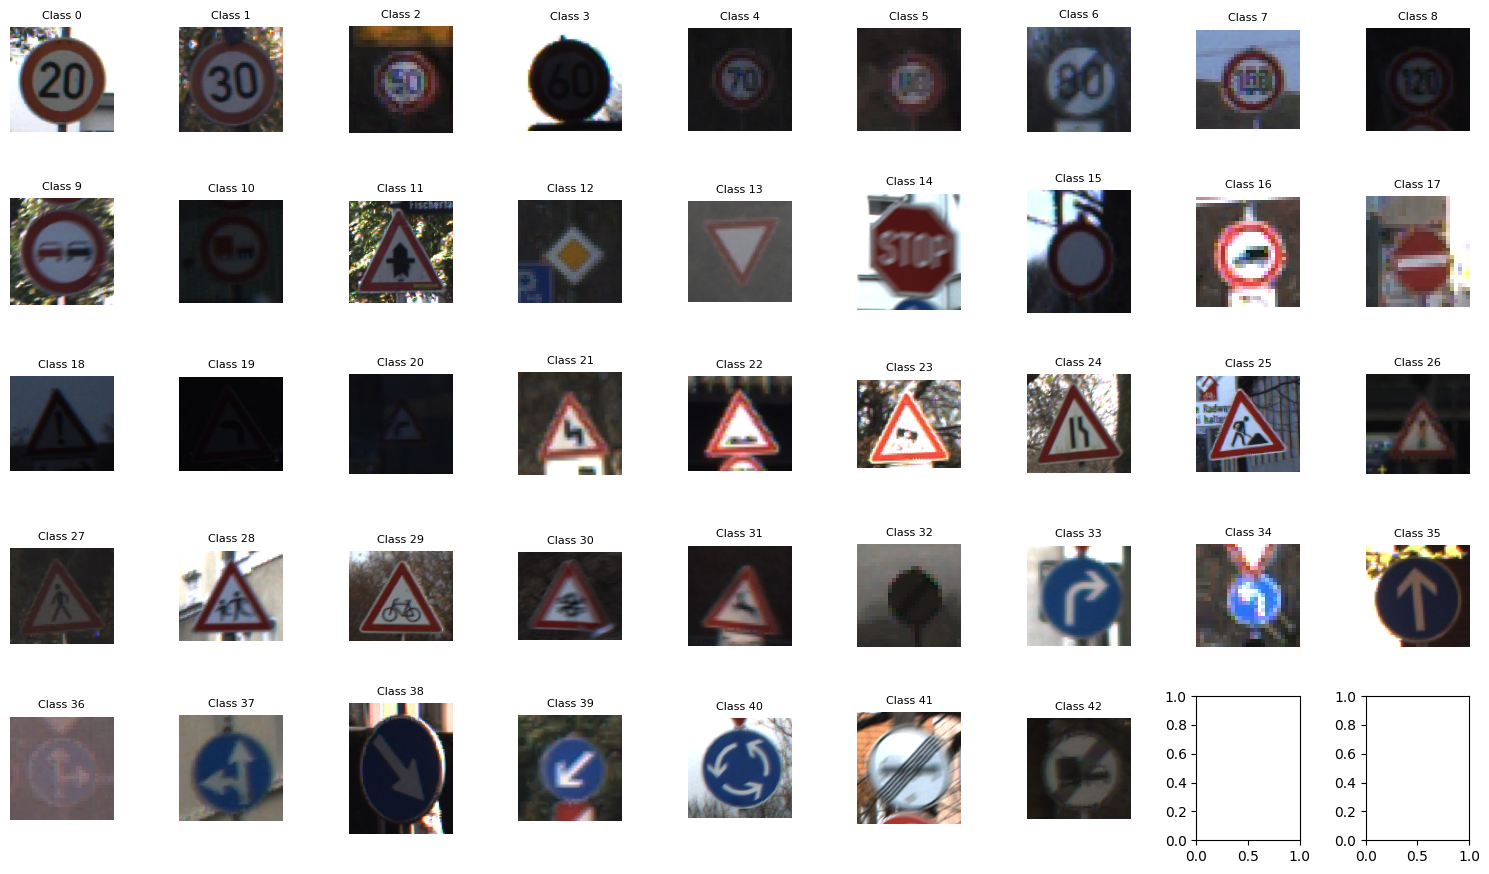

In [10]:
fig, axes = plt.subplots(5, 9, figsize=(15, 9))
axes = axes.flatten()

labels_train = [label for _, label in train_base_raw]
for class_id in range(NUM_CLASSES):
    idxs_cls = [i for i, label in enumerate(labels_train) if label == class_id]
    # Choose one random label index to plot
    idx = random.choice(idxs_cls)
    img, label = train_base_raw[idx]
    axes[class_id].imshow(img)
    axes[class_id].set_title(f"Class {label}", fontsize=8)
    axes[class_id].axis('off')

plt.tight_layout()
plt.show()

# **Main Dataset wrapper class to apply augmentations and perform class balancing**

In [ ]:
class AugmentedGTSRB(Dataset):
    """
    A dataset wrapper for GTSRB subsets that can:
      - Train mode: Oversample minority classes and apply training transforms
      - Validation/Test mode: Keep original class distribution and apply eval transforms
    """
    def __init__(self, base_subset_raw, transform=None,
                 oversample=False, min_samples_per_class=None,
                 num_classes=NUM_CLASSES):

        self.base = base_subset_raw  
        self.transform = transform       
        self.num_classes = num_classes   

        # Step 1: Build a dictionary mapping class_id -> list of local indices
        class_to_idx = {c: [] for c in range(self.num_classes)}
        for i in range(len(self.base)):
            _, y = self.base[i]     
            class_to_idx[int(y)].append(i)  

        # Step 2: Build the final list of indices to use
        if oversample:
            # Oversampling mode — ensure every class has at least `min_samples_per_class` samples
            if not min_samples_per_class:
                raise ValueError("Provide min_samples_per_class when oversample=True")

            self.indices = []
            for c in range(self.num_classes):
                idxs = class_to_idx[c]      
                if not idxs:                
                    continue
                # Determine how many samples we need for this class
                need = max(len(idxs), min_samples_per_class)
                # Randomly choose indices with replacement to match desired size
                chosen = np.random.choice(idxs, size=need, replace=True)
                self.indices.extend(chosen.tolist())
        else:
            # No oversampling — just keep the dataset as-is
            self.indices = list(range(len(self.base)))

    def __len__(self):
        """Return total number of samples (after any oversampling)."""
        return len(self.indices)

    def __getitem__(self, i):
        """
        Fetch a single (image, label) pair.
        Applies transform if provided.
        """
        local_i = self.indices[i]         
        img, y = self.base[local_i]      
        if self.transform is not None:     
            img = self.transform(img)
        return img, int(y)              


# **Make the augmented datasets for both resnet and mlp/cnn**

In [ ]:

MIN_COUNT = 800 # target floor per class for training balance

# Build a balanced dataset by oversampling minority classes up to `MIN_COUNT`

# 64x64 pipeline (CNN / MLP)
# Train dataset
train_64 = AugmentedGTSRB(
    base_subset_raw=train_base_raw,
    transform=train_transform_64,
    oversample=True,
    min_samples_per_class=MIN_COUNT,
    num_classes=NUM_CLASSES
)
# Validation dataset
val_64 = AugmentedGTSRB(
    base_subset_raw=val_base_raw,
    transform=test_transform_64,
    oversample=False,
    num_classes=NUM_CLASSES
)

# ResNet-50 pipeline (224x224, ImageNet stats)
# Train dataset
train_resnet = AugmentedGTSRB(
    base_subset_raw=train_base_raw,
    transform=train_transform_resnet,
    oversample=True,
    min_samples_per_class=MIN_COUNT,
    num_classes=NUM_CLASSES
)
# Validation dataset
val_resnet = AugmentedGTSRB(
    base_subset_raw=val_base_raw,
    transform=test_transform_resnet,
    oversample=False,
    num_classes=NUM_CLASSES
)

# **Check class frequencies after oversampling**

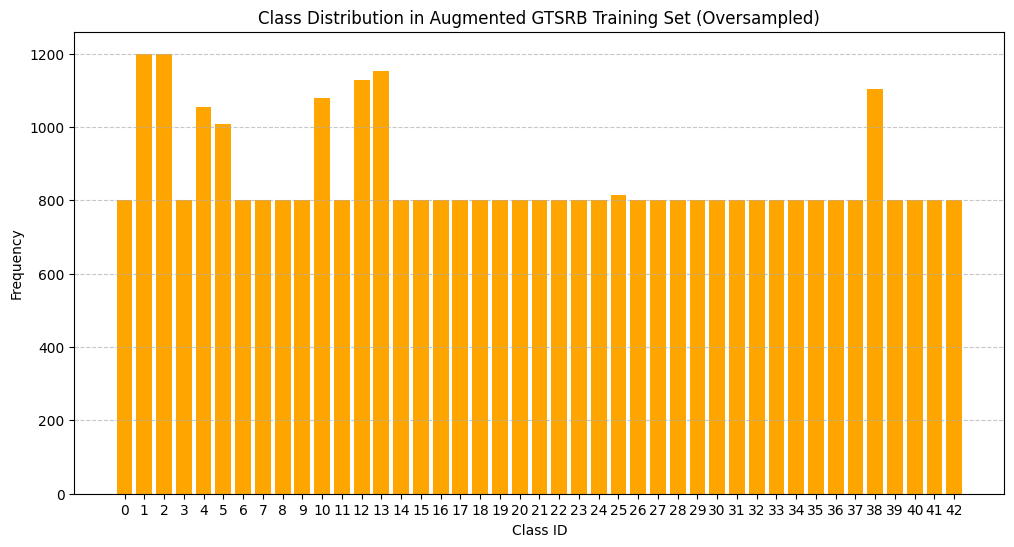

Minimum samples after augmentation: 800
Maximum samples after augmentation: 1200


In [17]:
# Extract labels from the augmented dataset
labels_aug = [label for _, label in train_64]

# Count occurrences
aug_class_counts = Counter(labels_aug)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(aug_class_counts.keys(), aug_class_counts.values(), color='orange')
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.title("Class Distribution in Augmented GTSRB Training Set (Oversampled)")
plt.xticks(range(NUM_CLASSES))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print min/max after augmentation
min_aug = min(aug_class_counts.values())
max_aug = max(aug_class_counts.values())
print(f"Minimum samples after augmentation: {min_aug}")
print(f"Maximum samples after augmentation: {max_aug}")

# **Make data loaders**

In [18]:
# DataLoaders for train/test/validation
def make_loader(ds, batch_size, shuffle):
    use_cuda = torch.cuda.is_available()
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=(4 if use_cuda else 0),
        pin_memory=use_cuda,
        persistent_workers=use_cuda
    )

# 64x64 loaders
train_loader_64 = make_loader(train_64, BATCH_SIZE, shuffle=True)
val_loader_64 = make_loader(val_64, BATCH_SIZE, shuffle=False)
test_loader_64 = make_loader(test_64, BATCH_SIZE, shuffle=False)

# ResNet loaders (224)
train_loader_resnet = make_loader(train_resnet, BATCH_SIZE, shuffle=True)
val_loader_resnet = make_loader(val_resnet, BATCH_SIZE, shuffle=False)
test_loader_resnet = make_loader(test_resnet, BATCH_SIZE, shuffle=False)

# Size checks
print(f"Train sizes -> 64x64: {len(train_64)} | ResNet: {len(train_resnet)}")
print(f"Val sizes -> 64x64: {len(val_64)} | ResNet: {len(val_resnet)}")
print(f"Test sizes -> 64x64: {len(test_64)} | ResNet: {len(test_resnet)}")


Train sizes -> 64x64: 36944 | ResNet: 36944
Val sizes -> 64x64: 5328 | ResNet: 5328
Test sizes -> 64x64: 12630 | ResNet: 12630


## Models and/or Methods

We implemented and compared three architectures:

- **Custom CNN**: A tailored convolutional neural network optimized for 64×64 GTSRB images, designed from scratch to efficiently capture spatial patterns while mitigating overfitting through dropout and batch normalization.
- **Multilayer Perceptron (MLP)**: A fully-connected baseline model to serve as a non-convolutional comparison, demonstrating the impact of spatial feature extraction.
- **Transfer Learning with ResNet-50**: Leveraging a pretrained ImageNet ResNet-50 backbone with partial layer freezing and a lightweight custom classifier head, enabling high accuracy with limited training data.

**Relation to Previous Work:**  
This work builds on established methods for GTSRB classification available in the open-source community, while introducing our own unified augmentation, oversampling, and evaluation pipeline. In particular, the following repositories informed aspects of model choice, training structure, and preprocessing:

- [mmoraes-rafael/gtsrb_resnet](https://github.com/mmoraes-rafael/gtsrb_resnet) – ResNet-based GTSRB classifier implemented in PyTorch.  
- [flymin/pytorch-gtsrb](https://github.com/flymin/pytorch-gtsrb) – Modular PyTorch implementation for GTSRB classification, including custom ResNet architectures and reusable training code.  
- [poojahira/gtsrb-pytorch](https://github.com/poojahira/gtsrb-pytorch) – End-to-end PyTorch baseline handling class imbalance and providing basic evaluation utilities.

**Our Contribution:**  
While these prior works provided high-level inspiration for architecture selection and dataset handling, all models in this project were implemented independently, with:
- A unified AugmentedGTSR dataset wrapper supporting stratified splitting, oversampling, and transform pipelines for train/val/test.
- A standardized training loop with automatic mixed precision (AMP), **gradient clipping**, and a **ReduceLROnPlateau** learning rate scheduler.
- An evaluation framework computing macro/micro metrics, confusion matrices, per-class analysis, and visualization of correct and incorrect predictions.


## **Model 1 – Custom CNN Classifier**

This is a **custom-designed Convolutional Neural Network (CNN)** built specifically for the German Traffic Sign Recognition Benchmark (GTSRB) dataset.  
It processes **64×64 RGB images** and consists of **three convolutional blocks** followed by a fully connected classifier.

**Convolutional Blocks**  
Each block contains:
- Two convolution layers for feature extraction  
- Batch Normalization to stabilize training  
- ReLU activation for non-linearity  
- Max Pooling to reduce spatial size and retain important features  
- Dropout to reduce overfitting  

The network increases the number of channels as it goes deeper (`64 → 128 → 256`) while reducing the spatial size (`64×64 → 32×32 → 16×16 → 8×8`), allowing it to capture progressively more abstract patterns.

**Classifier**  
After the feature extraction stage, the output is flattened and passed through:
- A fully connected layer with 512 neurons and ReLU activation  
- Dropout for regularization  
- A final output layer with **43 neurons** (one for each traffic sign class)

**Purpose**  
The model first learns **low-level visual features** (edges, colors, textures) and then progressively builds up to **high-level patterns** (traffic sign shapes and symbols), enabling accurate classification even under variations in lighting, rotation, and scale.


In [ ]:
# -------- Model 1: CNN --------
class Custom_CNNClassifier(nn.Module):
    """
    Deep Convolutional Neural Network for traffic sign classification on GTSRB.
    - Input: 3x64x64 RGB image
    - Architecture: 3 convolutional blocks (Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool -> Dropout)
      followed by a fully-connected classifier.
    - Each block increases the number of channels while reducing spatial dimensions by half.
    - Uses batch normalization for stable training and dropout for regularization.
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super(Custom_CNNClassifier, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            # Block 1: Input 3 channels → 64 channels
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # Output: 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),# Still 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # Downsample: 64x64 → 32x32
            nn.Dropout(0.25),

            # Block 2: 64 → 128 channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: 128x32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),# Output: 128x32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 32x32 → 16x16
            nn.Dropout(0.25),

            # Block 3: 128 → 256 channels
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# Output: 256x16x16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),# Output: 256x16x16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 16x16 → 8x8
            nn.Dropout(0.25),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),   # Flatten to 256 * 8 * 8 features
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output logits for classification
        )

    def forward(self, x):
        """Forward pass: extract convolutional features, then classify."""
        x = self.features(x)
        x = self.classifier(x)
        return x


## **Model 2 – Multilayer Perceptron**

This model is a **fully-connected neural network (MLP)** that classifies traffic signs from **64×64 RGB images** by first flattening each image into a single long vector of **12,288** numbers and then passing it through several dense layers.

**How it works**
- **Flattening** converts the image from `[3 × 64 × 64]` into a 12,288-dimensional vector.
- The vector goes through **four hidden layers** with:
  - **Batch Normalization** to stabilize training  
  - **ReLU activations** to learn non-linear patterns  
  - **Dropout** to reduce overfitting  
- A final dense layer outputs **43 logits** (one per class).

**What to expect**
- MLPs are simple and fast to train, but they **ignore spatial structure** (e.g., edges, shapes, local patterns), which often makes them weaker than CNNs on image tasks.  
- It serves as a useful **baseline** to show the benefit of spatial feature learning in CNNs and transfer learning models.


In [27]:
# -------- Model 2: Multilayer Perceptron (MLP) --------
class Custom_MLPClassifier(nn.Module):
    """
    Fully-connected (MLP) classifier for GTSRB.
    - Input: 3x64x64 RGB image (flattened to 12,288 features)
    - Architecture: 4 hidden layers with BatchNorm, ReLU, and Dropout
    - Note: Ignores spatial structure (treats image as a long vector)
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.net = nn.Sequential(
            # Flatten image to a feature vector: [B, 3, 64, 64] -> [B, 12288]
            nn.Flatten(),

            # Hidden layer 1: 12,288 -> 2,048
            nn.Linear(3*64*64, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            # Hidden layer 2: 2,048 -> 1,024
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            # Hidden layer 3: 1,024 -> 512
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            # Hidden layer 4: 512 -> 256
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            # Output: class logits (no activation here)
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """Forward pass through the MLP."""
        return self.net(x)


## **Model 3 – ResNet-50 Transfer Learning**

This model uses **transfer learning** with a pretrained **ResNet-50** architecture to classify traffic signs from the GTSRB dataset.

**How it works**
- **Input size**: 224×224 RGB images, normalized using ImageNet statistics.  
- **Backbone**: ResNet-50 pretrained on ImageNet, which already knows how to detect general visual features (edges, textures, object parts).  
- **Layer freezing**:  
  - Optionally freeze early layers to speed up training and prevent overfitting.  
  - Always unfreeze the **last residual block** to adapt to traffic sign features.  
- **Classifier head**: Replaces the original FC layer with:
  - Dense layer (512 units) + BatchNorm + ReLU + Dropout  
  - Final dense layer with **43 outputs** (one for each class).

**Why ResNet-50?**
- It is a **deep residual network** that can learn very complex patterns without vanishing gradients thanks to its **skip connections**.  
- Using pretrained weights means we start from a strong baseline, requiring less data and training time to achieve high accuracy.

**Expected performance**
- Typically achieves **much higher accuracy** than CNN and MLP baselines, especially with fine-tuning.


In [28]:
# -------- Model 3: ResNet-50 (Transfer Learning) --------
class ResNet50Classifier(nn.Module):
    """
    Transfer learning model for GTSRB using a pretrained ResNet-50 backbone.
    - Input: 3x224x224 RGB images (normalized with ImageNet mean & std)
    - Backbone: ResNet-50 pretrained on ImageNet
    - Optional: Freeze early layers for faster training
    - Custom classification head for NUM_CLASSES
    """
    def __init__(self, num_classes=NUM_CLASSES, freeze_layers=True):
        super().__init__()

        # Load ResNet-50 pretrained on ImageNet
        self.backbone = models.resnet50(pretrained=True)

        # Optionally freeze all layers
        if freeze_layers:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Always unfreeze the last residual block for fine-tuning
        for p in self.backbone.layer4.parameters():
            p.requires_grad = True

        # Replace the final FC layer with identity
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output logits for classification
        )

    def forward(self, x):
        """
        Forward pass: Extract features with ResNet-50 backbone,
        then classify with custom head.
        """
        feats = self.backbone(x)      # Shape: [B, 2048]
        return self.classifier(feats) # Shape: [B, num_classes]


## **Training Procedure**

Our training loop is designed to train fast, stay stable, and stop at the best model. Below is what happens each epoch and why each choice fits the GTSRB task.

### 1) Loss Function
- **Cross-Entropy Loss** for multi-class classification.
- Measures how far the model’s predicted probabilities are from the true class.
- Lower loss - better predictions.

### 2) Optimizer
- **Adam** (learning rate `1e-3`, weight decay `1e-4` by default).
- Adapts the learning rate per-parameter and keeps momentum, so it converges quickly.
- Works well for image tasks with varied lighting/angles like GTSRB.

### 3) Learning-Rate Scheduler
- **ReduceLROnPlateau** (monitor **validation accuracy**).
- If val accuracy stops improving for a few epochs, it **halves the LR**.
- Big LR early helps learn general patterns; smaller LR later helps fine-tune details.

### 4) Checkpointing (Early Best)
- After each epoch, if **validation accuracy** improves, we **save the model**.
- Guarantees we keep the **best-performing weights**, not just the final epoch.

### 5) What Happens in Each Epoch
1. **Train phase**  
   - Forward pass on training batches  
   - Compute loss → backward pass  
   - (AMP) scale/unscale grads → **clip grads** → optimizer step  
   - Track **train loss** and **train accuracy**
2. **Validation phase**  
   - Disable gradients, run forward pass on val set  
   - Track **val loss** and **val accuracy**  
   - Step the **scheduler** with the new val accuracy  
   - **Save checkpoint** if this is the best so far


### 6) Why This Setup Suits GTSRB
- **Adam + ReduceLROnPlateau** handle noisy gradients and let us fine-tune late training.
- **Best-checkpoint saving** ensures the final model used is the strongest on validation data.


In [ ]:

# Training loop
def train_loop(model, train_loader, val_loader, device, ckpt_path,
               num_epochs=30, lr=1e-3, weight_decay=1e-4, grad_clip=None):
    """
    Train `model` using `train_loader`, validate on `val_loader`,
    save the best weights (by validation accuracy) to `ckpt_path`,
    and return metric histories.
    """
    # Move model to target device (CPU/GPU)
    model.to(device)

    # Loss, optimizer, LR scheduler
    loss_fn  = nn.CrossEntropyLoss()   # multi-class classification
    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',        # we monitor accuracy (higher is better)
        factor=0.5,  # halve LR on plateau
        patience=3,      # epochs to wait before reducing LR
        verbose=True
    )

  
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    # Recording history
    best_acc, best_epoch = 0.0, -1                    
    tr_loss_hist, tr_acc_hist = [], []            
    val_loss_hist, val_acc_hist = [], []             

    start = time.perf_counter()              

    for epoch in range(num_epochs):

        # --- Training epoch ---

        model.train()

        tot_loss = 0.0
        tot_correct = 0
        tot = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)       
            optimizer.zero_grad(set_to_none=True)    

            if scaler:
              # Forward + loss (mixed precision)
              with torch.cuda.amp.autocast():
                out = model(x)
                loss = loss_fn(out, y)
              # Backward
              scaler.scale(loss).backward()
          
              if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
              # Optimizer step + scaler update
              scaler.step(optimizer)
              scaler.update()
            else:
           
              out = model(x)
              loss = loss_fn(out, y)
              loss.backward()

           
              if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

              optimizer.step()

            # accumulate metrics (sum over samples)
            tot_loss += loss.item() * x.size(0)
            tot_correct += (out.argmax(1) == y).sum().item()
            tot += y.size(0)

        tr_loss = tot_loss / tot                      # average train loss
        tr_acc  = tot_correct / tot                   # average train accuracy
        tr_loss_hist.append(tr_loss)
        tr_acc_hist.append(tr_acc)

        # --- Validation epoch ---
        model.eval()
        v_loss = 0.0
        v_correct = 0
        v_tot = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out  = model(x)
                loss = loss_fn(out, y)

                v_loss += loss.item() * x.size(0)
                v_correct += (out.argmax(1) == y).sum().item()
                v_tot += y.size(0)

        val_loss = v_loss / v_tot                     # average val loss
        val_acc  = v_correct / v_tot                  # average val accuracy
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        # Epoch summary
        print(f"Epoch {epoch+1}: Train {tr_loss:.4f}/{tr_acc*100:.2f}% | "
              f"Val {val_loss:.4f}/{val_acc*100:.2f}%")

        # Step LR scheduler on validation accuracy
        scheduler.step(val_acc * 100)

        # save best checkpoint (by highest val accuracy)
        if val_acc > best_acc:
            best_acc, best_epoch = val_acc, epoch + 1
            torch.save(model.state_dict(), ckpt_path)
            print(f"Saved best to {ckpt_path}: {best_acc*100:.2f}%, epoch {best_epoch})")

    # training summary
    elapsed_min = (time.perf_counter()-start)/60
    print(f"Finished in {elapsed_min:.2f} min. Best {best_acc*100:.2f}%, epoch {best_epoch}")

    # return histories and best epoch
    return tr_loss_hist, tr_acc_hist, val_loss_hist, val_acc_hist, best_epoch

## **Helper Functions to Visualize Results**

In [ ]:
# --- Unnormalize helper ---
def unnormalize(img_tensor, mean, std):
    img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    mean = np.array(mean).reshape(1,1,3)
    std  = np.array(std).reshape(1,1,3)
    img = img * std + mean
    return np.clip(img, 0, 1)

# --- Train/Val curves ---
def plot_training_curves(tr_loss_hist, tr_acc_hist, val_loss_hist, val_acc_hist, title_suffix=""):
    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(tr_loss_hist, label="Train Loss")
    plt.plot(val_loss_hist, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss over Epochs{title_suffix}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("curves_loss.png")
    plt.show()

    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(tr_acc_hist, label="Train Acc")
    plt.plot(val_acc_hist, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy over Epochs{title_suffix}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("curves_acc.png")
    plt.show()

# --- Confusion matrix plot ---
def plot_confusion(cm, normalize=False, num_classes=43, title=None):
    disp = cm.astype(float)
    if normalize:
        # row-normalize: divide each row by its sum
        row_sums = disp.sum(axis=1, keepdims=True) + 1e-12
        disp = (disp / row_sums) * 100.0

    plt.figure(figsize=(12,10))
    plt.imshow(disp, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar(label=("% within true class" if normalize else "count"))
    ticks = np.arange(num_classes)
    plt.xticks(ticks, ticks, rotation=90)
    plt.yticks(ticks, ticks)

    # annotate cells (only the informative ones)
    thresh = 50 if normalize else (disp.max()/2.0 if disp.max() > 0 else 1)
    for i, j in itertools.product(range(num_classes), range(num_classes)):
        val = disp[i, j]
        show = (val >= 1.0) if normalize else (val > 0)
        if show:
            txt = f"{val:.0f}%" if normalize else str(int(val))
            plt.text(j, i, txt, ha="center", va="center",
                     color="white" if val > thresh else "black", fontsize=6)

    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()

# --- One image per class with per-class counts ---
def show_one_image_per_class_with_counts(dataset, y_true, y_pred, num_classes, mean, std):
    """
    Shows 1 random image per class from the given dataset (same indexing as y_true/y_pred),
    and annotates the title with:
      - total true count of that class in the dataset
      - correctly predicted count (diagonal of CM)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

   
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    per_class_true   = cm.sum(axis=1) 
    per_class_correct= cm.diagonal()   

    # For each class, pick a random index of that class
    by_class_indices = {c: np.where(y_true == c)[0] for c in range(num_classes)}

    rows, cols = 5, 9  # 5x9 grid (43 classes fit)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
    axes = axes.flatten()

    for c in range(num_classes):
        ax = axes[c]
        idxs = by_class_indices[c]
       
        k = random.choice(idxs)
        img, _ = dataset[k]
        ax.imshow(unnormalize(img, mean, std))
        ax.set_title(f"Class {c}\nTrue: {per_class_true[c]}, Correct: {per_class_correct[c]}", fontsize=7)
        ax.axis('off')

    # hide extra axes if any
    for k in range(num_classes, rows*cols):
        axes[k].axis('off')

    plt.tight_layout()
    plt.savefig("one_per_class_with_counts.png")
    plt.show()

# --- Misclassified images grid ---
def show_misclassified_images(dataset, y_true, y_pred, mean, std, max_images=10):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("No misclassified images.")
        return
   
    chosen = np.random.choice(wrong, size=min(max_images, len(wrong)), replace=False)

    cols = min(5, len(chosen))
    rows = int(np.ceil(len(chosen)/cols))
    plt.figure(figsize=(3.2*cols, 3.2*rows))

    for i, idx in enumerate(chosen, 1):
        img, _ = dataset[idx]
        plt.subplot(rows, cols, i)
        plt.imshow(unnormalize(img, mean, std))
        plt.title(f"True: {int(y_true[idx])}, Pred: {int(y_pred[idx])}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("misclassified_examples.png")
    plt.show()

## **Evaluation Procedure**

After training the models, we implemented a evaluation loop to assess their performance on the **unseen test dataset**. The evaluation stage is designed to provide both macro and micro into insights model behavior.

---

### **1. Model Loading**
- A **model instance** is created using the chosen architecture (`model_ctor`).
- The **best saved weights** (from training) are loaded from the checkpoint file.
- The model is switched to **evaluation mode** to disable dropout and batch norm updates.

---

### **2. Predictions on the Test Set**
- The model processes the test set in batches using the `test_loader`.
- For each batch:
  - The inputs are passed through the model.
  - The predicted class index is obtained using `argmax`.
  - Predictions and ground truth labels are stored for later analysis.

---

### **3. Performance Metrics**
We computed both **macro** and **micro**-averaged classification metrics:

| Metric Type  | What It Measures | Why It’s Used |
|--------------|------------------|--------------|
| **Accuracy** | Overall proportion of correctly predicted samples | Gives a global performance measure |
| **Macro Precision / Recall / F1** | Averages metrics across all classes equally | Suitable for imbalanced datasets, ensures each class is treated equally |
| **Micro Precision / Recall / F1** | Aggregates contributions of all classes before computing metrics | Reflects overall effectiveness, weighted by class frequency |
---

### **4. Confusion Matrix**
- We generate a **confusion matrix** to visualize per-class prediction behavior.
- shows the percentage of correctly and incorrectly classified samples for each class.
- This helps identify **which classes are most often confused** with each other.

---

### **5. Per-Class Analysis**
- For each class:
  - The **total number of test samples** is shown.
  - The **number of correctly predicted samples** is shown.
  - A **representative image** from that class is displayed.
- This gives an intuitive understanding of **per-class strengths and weaknesses**.

---

### **6. Error Analysis**

- We randomly sample **10 misclassified images**.
- For each, we display:
  - The **input image** (unnormalized for human viewing).
  - The **true class label**.
  - The **predicted class label**.
- This allows for visual inspection of **failure cases** to identify patterns (e.g., similar-looking signs, poor lighting, or motion blur).

---



In [ ]:
# Testing
def test_loop(
    model_ctor,
    ckpt_path,
    test_loader,
    test_dataset,
    device,
    num_classes=NUM_CLASSES,
    mean=(0.3403, 0.3121, 0.3214),
    std=(0.2724, 0.2608, 0.2669),
    normalize_cm=True,
    show_confusion=True,
    show_one_per_class=True,
    show_missed=True,
    max_missed=10
):
    """
    Loads model via model_ctor(), loads weights from ckpt_path, evaluates on test_loader.
    Prints Accuracy + Macro/Micro Precision/Recall/F1 in a table and:
    - plots confusion matrix
    - shows one image per class with true+correct counts
    - shows a grid of misclassified images (up to max_missed)
    """

    # Load model
    model = model_ctor().to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # Collect predictions
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(1).cpu().numpy()
            labels = y.numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    all_preds = np.asarray(all_preds)
    all_labels= np.asarray(all_labels)

    # Metrics 
    acc  = accuracy_score(all_labels, all_preds)
    p_ma, r_ma, f1_ma, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    p_mi, r_mi, f1_mi, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro', zero_division=0)

    # Table
    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 (Macro)", "Precision (Micro)", "Recall (Micro)", "F1 (Micro)"],
        "Score":  [acc,        p_ma,                r_ma,             f1_ma,         p_mi,                r_mi,             f1_mi]
    })
    # Print metrics
    print(metrics_df.to_string(index=False))

    #  Confusion Matrix 
    if show_confusion:
        cm_counts = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
        plot_confusion(cm_counts, normalize=normalize_cm, num_classes=num_classes)

    #  One image per class with counts 
    if show_one_per_class:
        show_one_image_per_class_with_counts(
            dataset=test_dataset,
            y_true=all_labels,
            y_pred=all_preds,
            num_classes=num_classes,
            mean=mean, std=std
        )

    #  Misclassified images 
    if show_missed:
        show_misclassified_images(
            dataset=test_dataset,
            y_true=all_labels,
            y_pred=all_preds,
            mean=mean, std=std,
            max_images=max_missed
        )

    return metrics_df

## **Train the CNN model and plot the curves**

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-1331055348.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
/tmp/ipython-input-1331055348.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Train 3.7704/4.64% | Val 2.7378/17.72%
Saved best to gtsrb_cnn.pth: 17.72%, epoch 1)
Epoch 2: Train 2.0808/33.35% | Val 1.0768/62.44%
Saved best to gtsrb_cnn.pth: 62.44%, epoch 2)
Epoch 3: Train 0.7852/73.41% | Val 0.0836/97.48%
Saved best to gtsrb_cnn.pth: 97.48%, epoch 3)
Epoch 4: Train 0.2688/91.53% | Val 0.0420/98.63%
Saved best to gtsrb_cnn.pth: 98.63%, epoch 4)
Epoch 5: Train 0.1681/94.94% | Val 0.0311/99.29%
Saved best to gtsrb_cnn.pth: 99.29%, epoch 5)
Epoch 6: Train 0.1387/95.98% | Val 0.0361/99.23%
Epoch 7: Train 0.1159/96.74% | Val 0.0284/99.19%
Epoch 8: Train 0.1112/96.95% | Val 0.0323/99.44%
Saved best to gtsrb_cnn.pth: 99.44%, epoch 8)
Epoch 9: Train 0.0993/97.30% | Val 0.0294/99.42%
Epoch 10: Train 0.0956/97.37% | Val 0.0284/99.27%
Epoch 11: Train 0.0893/97.56% | Val 0.0224/99.57%
Saved best to gtsrb_cnn.pth: 99.57%, epoch 11)
Epoch 12: Train 0.0932/97.59% | Val 0.0330/99.25%
Epoch 13: Train 0.0839/97.72% | Val 0.0208/99.70%
Saved best to gtsrb_cnn.pth: 99.70%, 

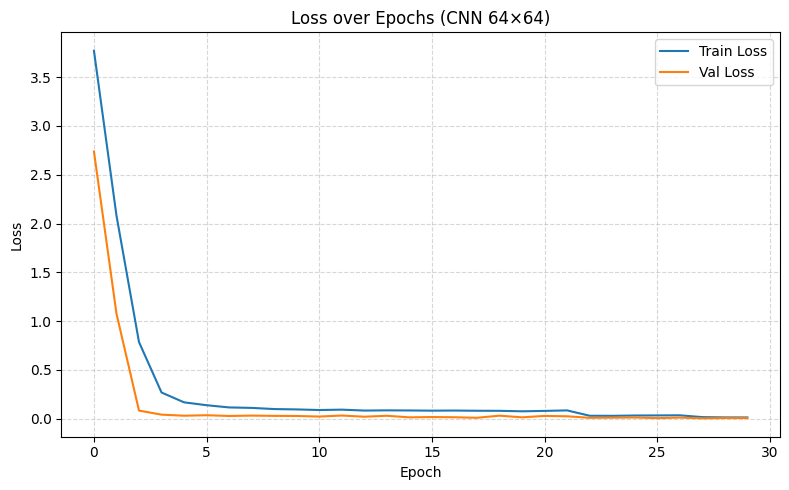

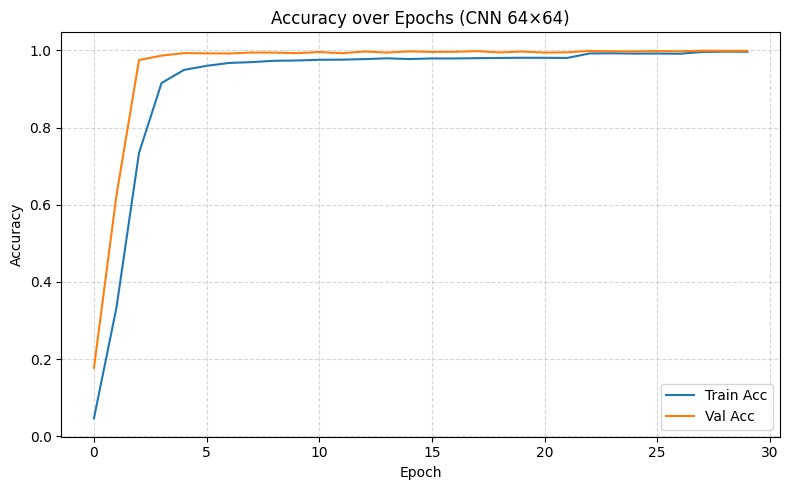

Best epoch (by val acc): 28


In [ ]:
# Train CNN + Plot Curves

cnn_model =  Custom_CNNClassifier(num_classes=NUM_CLASSES)

cnn_ckpt = "gtsrb_cnn.pth"

train_loss_history, train_acc_history, val_loss_history, val_acc_history, best_epoch = train_loop(
    model=cnn_model,
    train_loader=train_loader_64,      # 64×64 pipeline
    val_loader=val_loader_64,
    device=device,
    ckpt_path=cnn_ckpt,
    num_epochs=30,
    lr=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0                   
)

# Plot train/val curves (loss + accuracy)
plot_training_curves(
    tr_loss_hist=train_loss_history,
    tr_acc_hist=train_acc_history,
    val_loss_hist=val_loss_history,
    val_acc_hist=val_acc_history,
    title_suffix=" (CNN 64×64)"
)
print(f"Best epoch (by val acc): {best_epoch}")


## **Test the CNN model, record the metrics and plot the results**

           Metric    Score
         Accuracy 0.988440
Precision (Macro) 0.983161
   Recall (Macro) 0.979886
       F1 (Macro) 0.979838
Precision (Micro) 0.988440
   Recall (Micro) 0.988440
       F1 (Micro) 0.988440


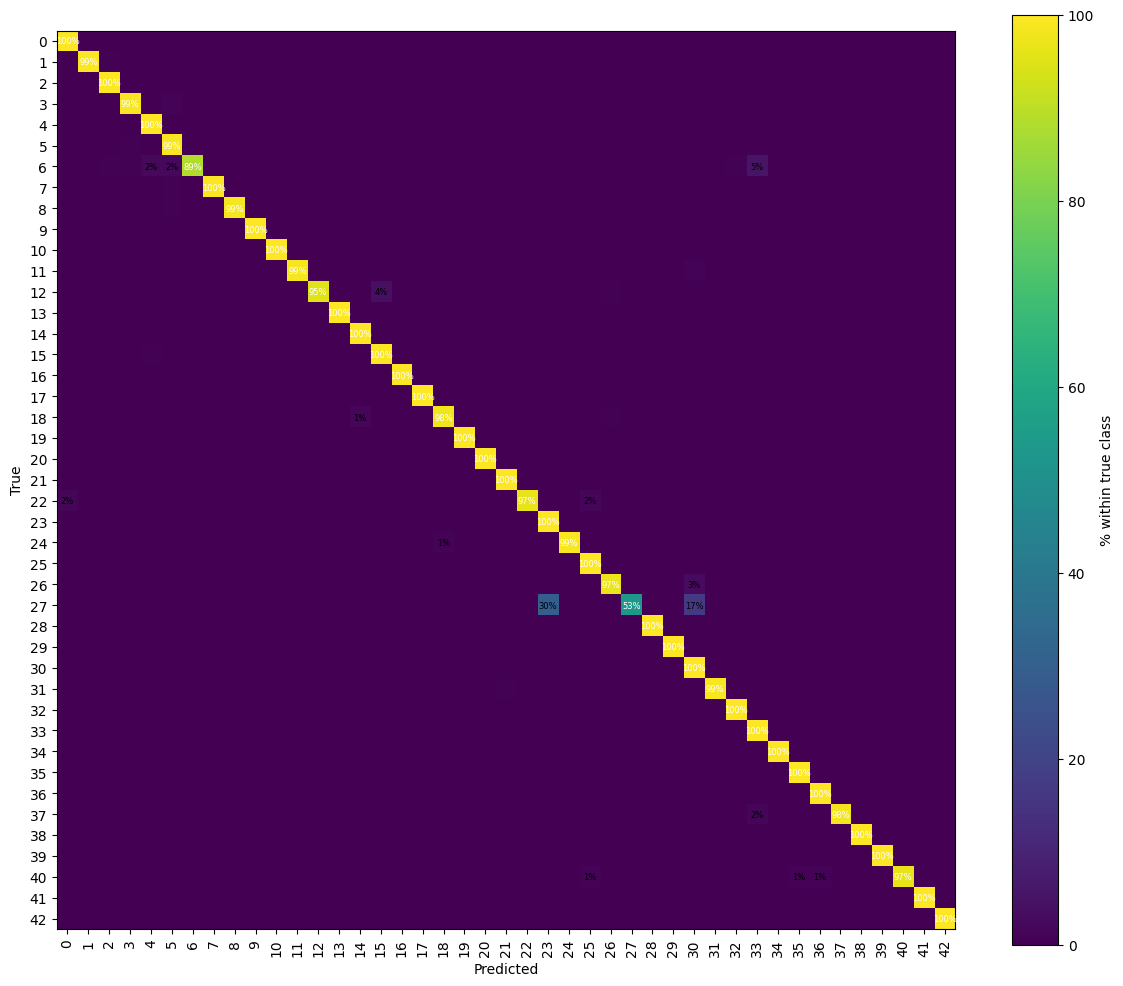

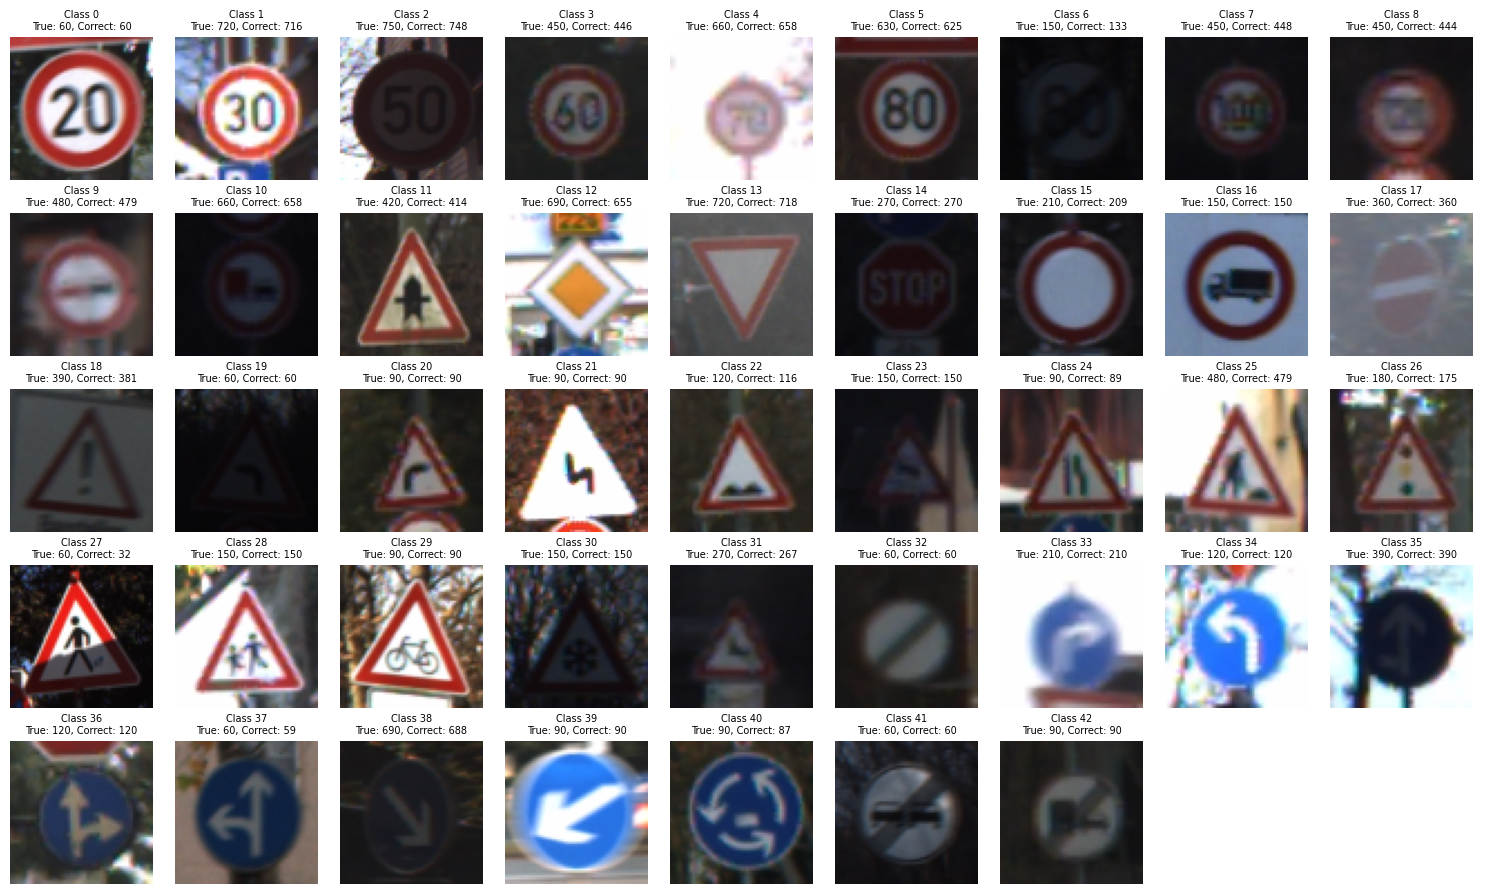

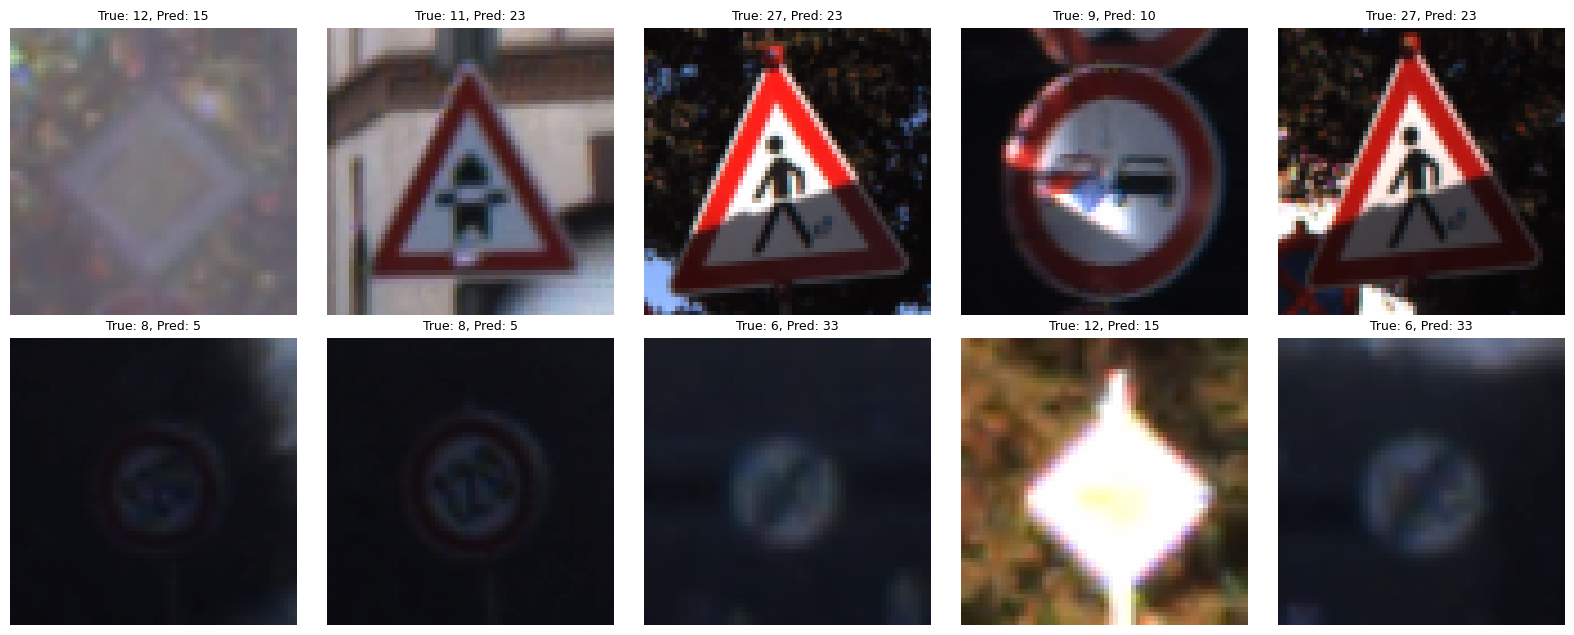

In [ ]:
# Evaluate CNN (64×64 pipeline) and return metrics DF

cnn_metrics_df = test_loop(
    model_ctor=lambda: Custom_CNNClassifier(num_classes=NUM_CLASSES),
    ckpt_path="gtsrb_cnn.pth",   # path you saved in training
    test_loader=test_loader_64,       # 64×64 test loader
    test_dataset=test_64,            
    device=device,
    num_classes=NUM_CLASSES,
    mean=(0.3403, 0.3121, 0.3214),     # GTSRB stats for un-normalization
    std=(0.2724, 0.2608, 0.2669),
    normalize_cm=True,                  
    show_confusion=True,
    show_one_per_class=True,
    show_missed=True,
    max_missed=10
)

## **Train the MLP model and plot the curves**

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-1331055348.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
/tmp/ipython-input-1331055348.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Train 2.9717/15.96% | Val 2.4370/25.99%
Saved best to gtsrb_mlp.pth: 25.99%, epoch 1)
Epoch 2: Train 2.5511/24.75% | Val 2.1129/33.20%
Saved best to gtsrb_mlp.pth: 33.20%, epoch 2)
Epoch 3: Train 2.3766/29.11% | Val 1.8543/41.97%
Saved best to gtsrb_mlp.pth: 41.97%, epoch 3)
Epoch 4: Train 2.2544/32.82% | Val 1.7122/46.98%
Saved best to gtsrb_mlp.pth: 46.98%, epoch 4)
Epoch 5: Train 2.1793/34.76% | Val 1.6170/49.16%
Saved best to gtsrb_mlp.pth: 49.16%, epoch 5)
Epoch 6: Train 2.1158/36.56% | Val 1.5512/53.00%
Saved best to gtsrb_mlp.pth: 53.00%, epoch 6)
Epoch 7: Train 2.0615/38.00% | Val 1.3925/58.78%
Saved best to gtsrb_mlp.pth: 58.78%, epoch 7)
Epoch 8: Train 2.0425/39.09% | Val 1.4321/54.67%
Epoch 9: Train 2.0125/39.75% | Val 1.4946/54.02%
Epoch 10: Train 2.0065/40.24% | Val 1.3492/60.51%
Saved best to gtsrb_mlp.pth: 60.51%, epoch 10)
Epoch 11: Train 1.9851/40.77% | Val 1.4309/54.02%
Epoch 12: Train 1.9768/41.07% | Val 1.3994/56.12%
Epoch 13: Train 1.9636/41.44% | Val 1.44

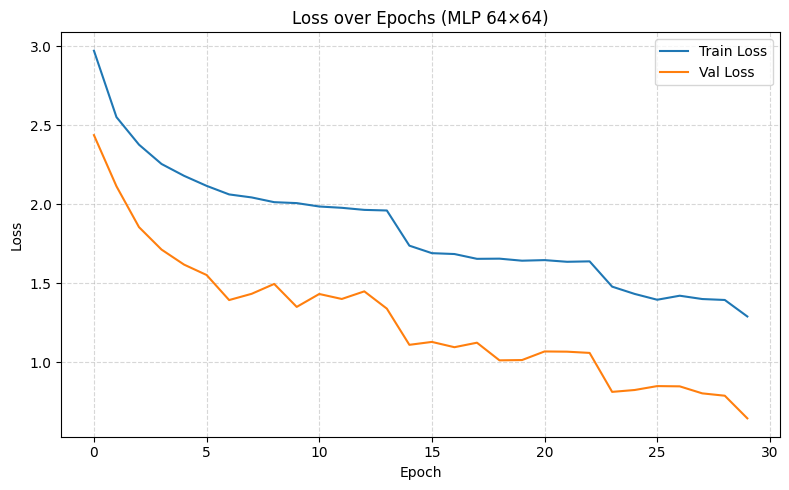

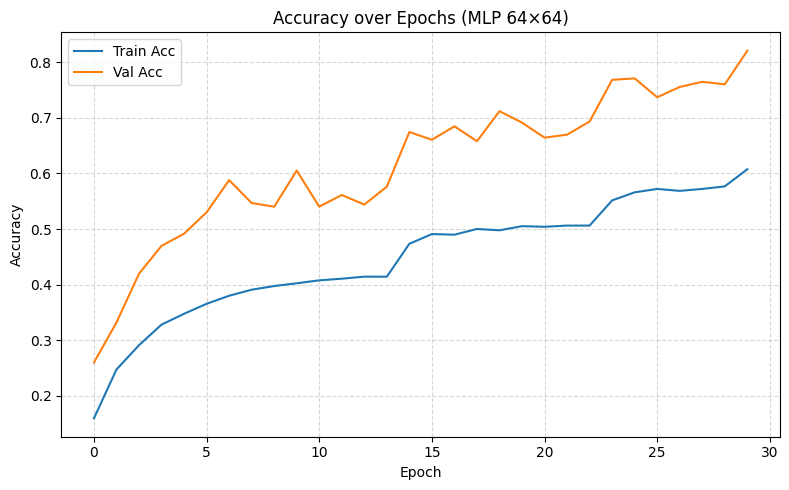

Best epoch (by val acc): 30


In [ ]:
# Train MLP + Plot Curves

mlp_model =  Custom_MLPClassifier(num_classes=NUM_CLASSES)

mlp_ckpt = "gtsrb_mlp.pth"

train_loss_history, train_acc_history, val_loss_history, val_acc_history, best_epoch = train_loop(
    model=mlp_model,
    train_loader=train_loader_64,      # 64×64 pipeline
    val_loader=val_loader_64,
    device=device,
    ckpt_path=mlp_ckpt,
    num_epochs=30,
    lr=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0                   
)

# Plot train/val curves (loss + accuracy)
plot_training_curves(
    tr_loss_hist=train_loss_history,
    tr_acc_hist=train_acc_history,
    val_loss_hist=val_loss_history,
    val_acc_hist=val_acc_history,
    title_suffix=" (MLP 64×64)"
)
print(f"Best epoch (by val acc): {best_epoch}")


## **Test the MLP model, record the metrics and plot the results**

           Metric    Score
         Accuracy 0.658432
Precision (Macro) 0.649011
   Recall (Macro) 0.652216
       F1 (Macro) 0.635014
Precision (Micro) 0.658432
   Recall (Micro) 0.658432
       F1 (Micro) 0.658432


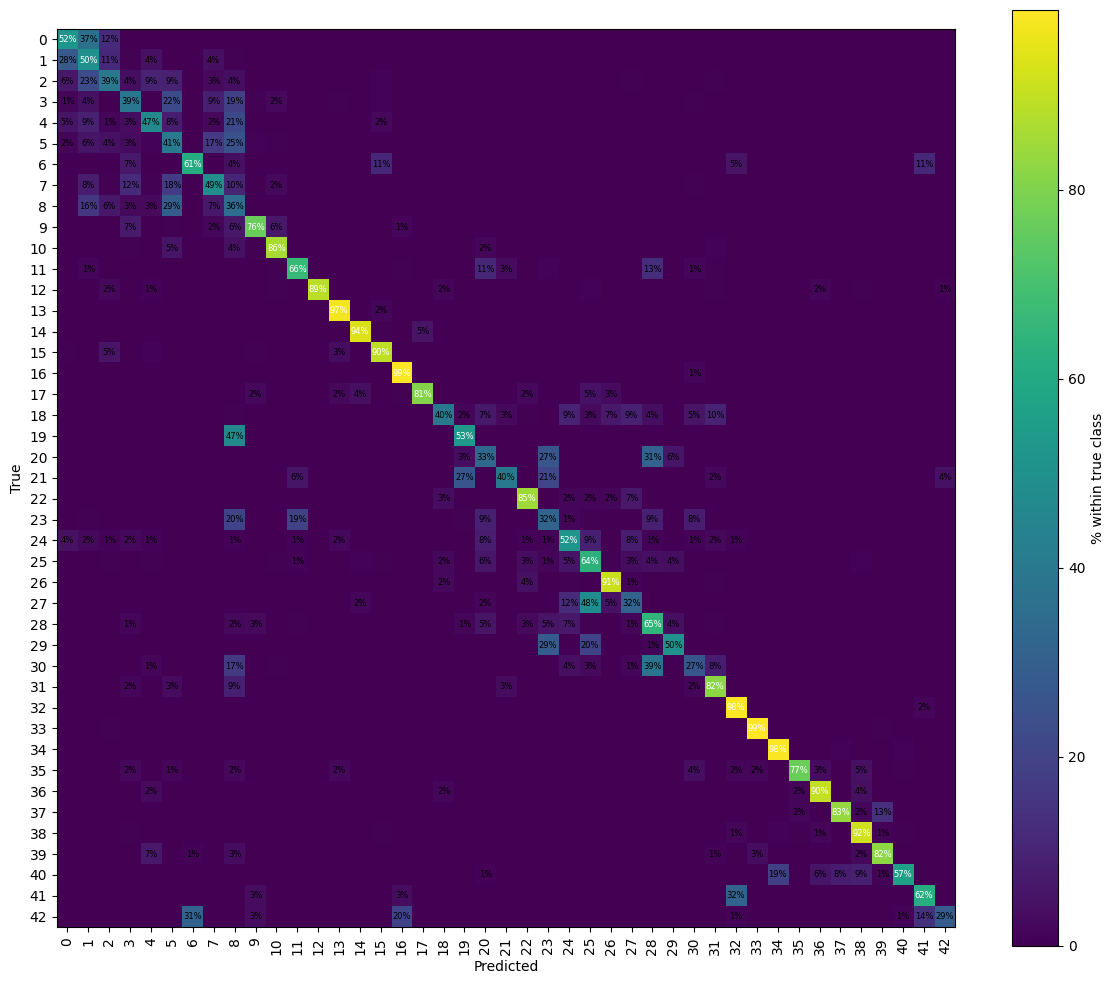

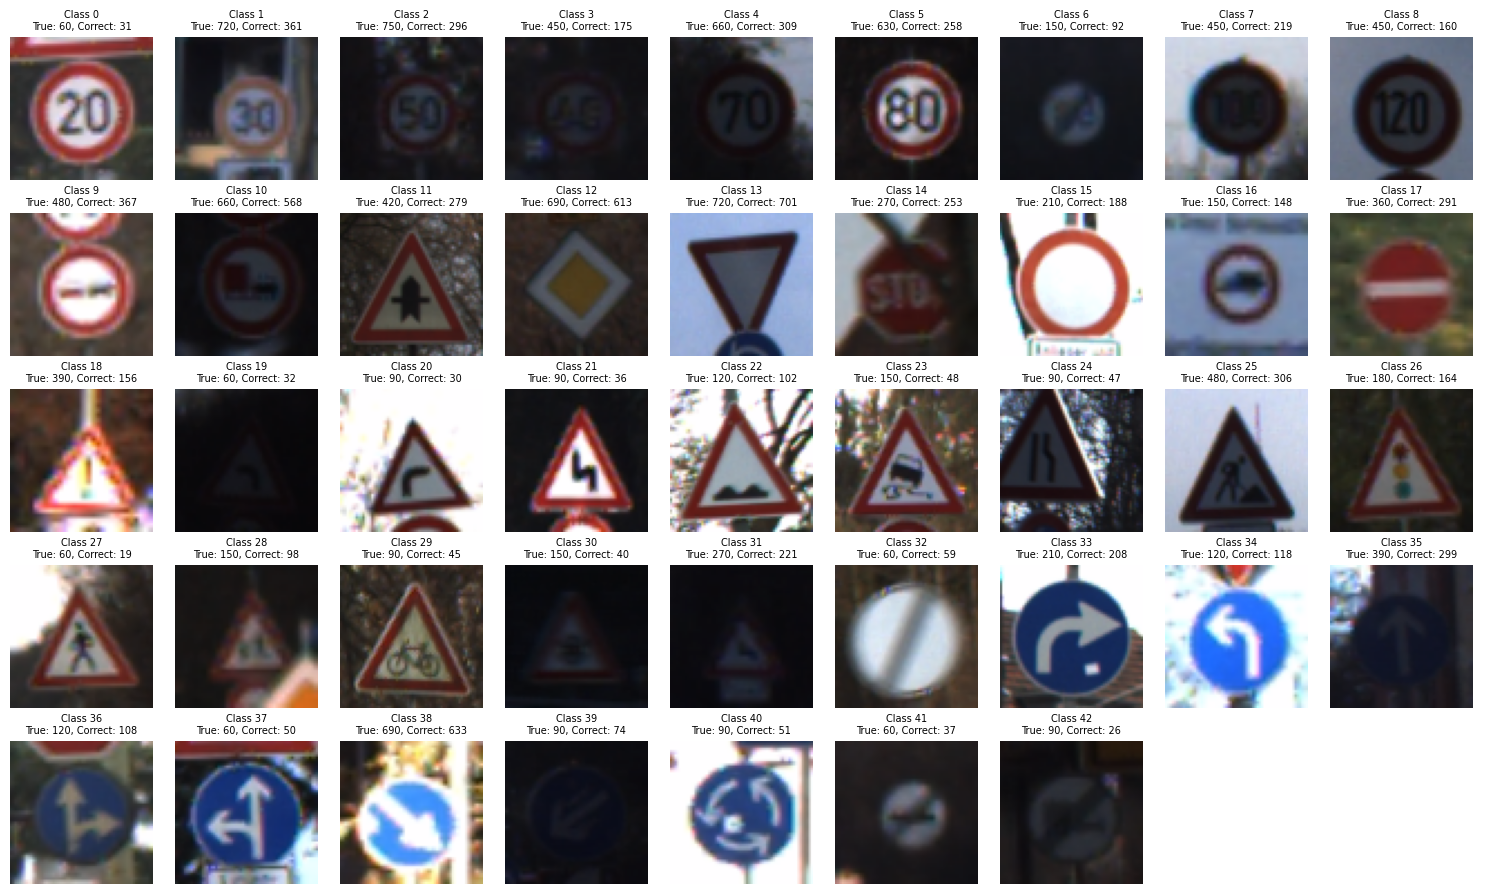

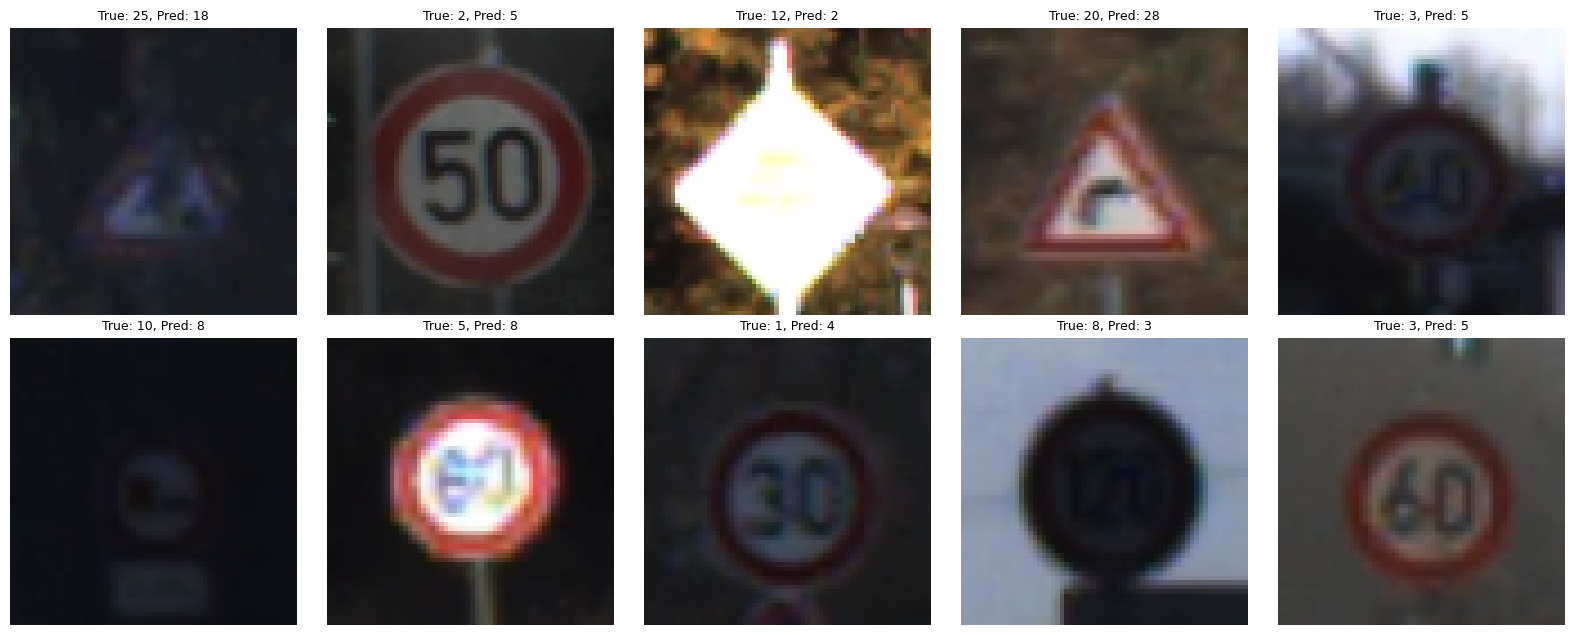

In [ ]:
# Evaluate MLP (64×64 pipeline) and return metrics DF

mlp_metrics_df = test_loop(
    model_ctor=lambda: Custom_MLPClassifier(num_classes=NUM_CLASSES),
    ckpt_path="gtsrb_mlp.pth",   # path you saved in training
    test_loader=test_loader_64,       # 64×64 test loader
    test_dataset=test_64,             
    device=device,
    num_classes=NUM_CLASSES,
    mean=(0.3403, 0.3121, 0.3214),     # GTSRB stats for un-normalization
    std=(0.2724, 0.2608, 0.2669),
    normalize_cm=True,                 
    show_confusion=True,
    show_one_per_class=True,
    show_missed=True,
    max_missed=10
)

## **Train the Resnet model and plot the curves**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch 1: Train 0.9387/71.78% | Val 0.2378/92.30%
Saved best to gtsrb_resnet.pth: 92.30%, epoch 1)
Epoch 2: Train 0.2641/91.91% | Val 0.1420/95.46%
Saved best to gtsrb_resnet.pth: 95.46%, epoch 2)
Epoch 3: Train 0.2097/93.73% | Val 0.1614/94.69%
Epoch 4: Train 0.1840/94.61% | Val 0.1544/95.42%
Epoch 5: Train 0.1747/94.84% | Val 0.1122/96.58%
Saved best to gtsrb_resnet.pth: 96.58%, epoch 5)
Epoch 6: Train 0.1811/94.70% | Val 0.1185/96.62%
Saved best to gtsrb_resnet.pth: 96.62%, epoch 6)
Epoch 7: Train 0.1688/95.04% | Val 0.1079/96.75%
Saved best to gtsrb_resnet.pth: 96.75%, epoch 7)
Epoch 8: Train 0.1629/95.17% | Val 0.1322/96.13%
Epoch 9: Train 0.1572/95.45% | Val 0.1297/96.34%
Epoch 10: Train 0.1581/95.42% | Val 0.0937/97.18%
Saved best to gtsrb_resnet.pth: 97.18%, epoch 10)
Epoch 11: Train 0.1580/95.45% | Val 0.1719/95.51%
Epoch 12: Train 0.1555/95.46% | Val 0.0767/97.79%
Saved best to gtsrb_resnet.pth: 97.79%, epoch 12)
Epoch 13: Train 0.1547/95.49% | Val 0.0984/97.05%
Epoch 14: Trai

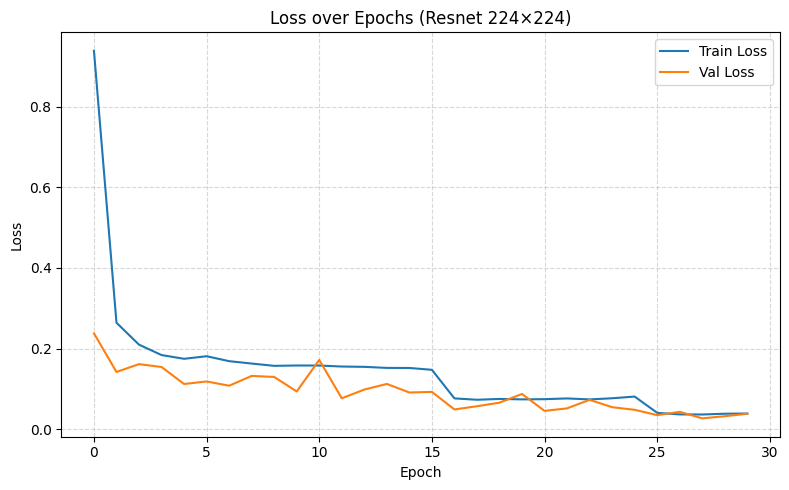

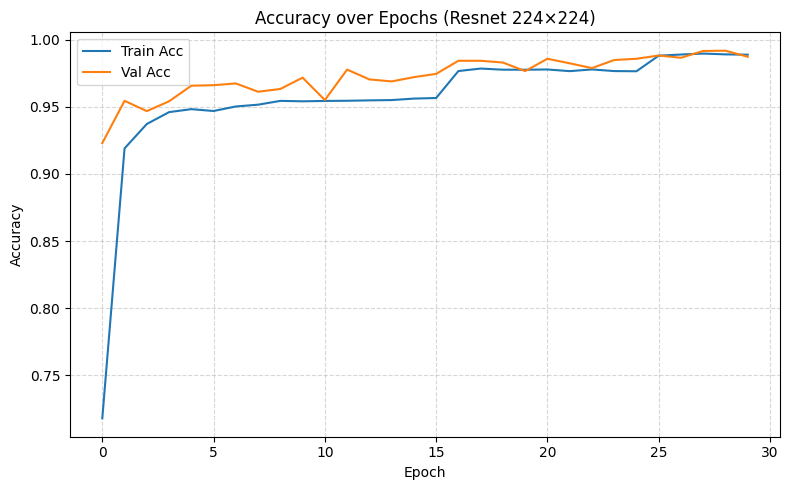

Best epoch (by val acc): 29


In [ ]:
# Train resnet + Plot Curves

resnet_model =  ResNet50Classifier(num_classes=NUM_CLASSES)

resnet_ckpt = "gtsrb_resnet.pth"

train_loss_history, train_acc_history, val_loss_history, val_acc_history, best_epoch = train_loop(
    model=resnet_model,
    train_loader=train_loader_resnet,      # 224x224 pipeline
    val_loader=val_loader_resnet,
    device=device,
    ckpt_path=resnet_ckpt,
    num_epochs=30,
    lr=5e-3,
    weight_decay=1e-4,
    grad_clip=1.0                    
)

# Plot train/val curves (loss + accuracy)
plot_training_curves(
    tr_loss_hist=train_loss_history,
    tr_acc_hist=train_acc_history,
    val_loss_hist=val_loss_history,
    val_acc_hist=val_acc_history,
    title_suffix=" (Resnet 224×224)"
)
print(f"Best epoch (by val acc): {best_epoch}")


## **Test the Resnet model, record the metrics and plot the results**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


           Metric    Score
         Accuracy 0.969675
Precision (Macro) 0.951391
   Recall (Macro) 0.967075
       F1 (Macro) 0.957855
Precision (Micro) 0.969675
   Recall (Micro) 0.969675
       F1 (Micro) 0.969675


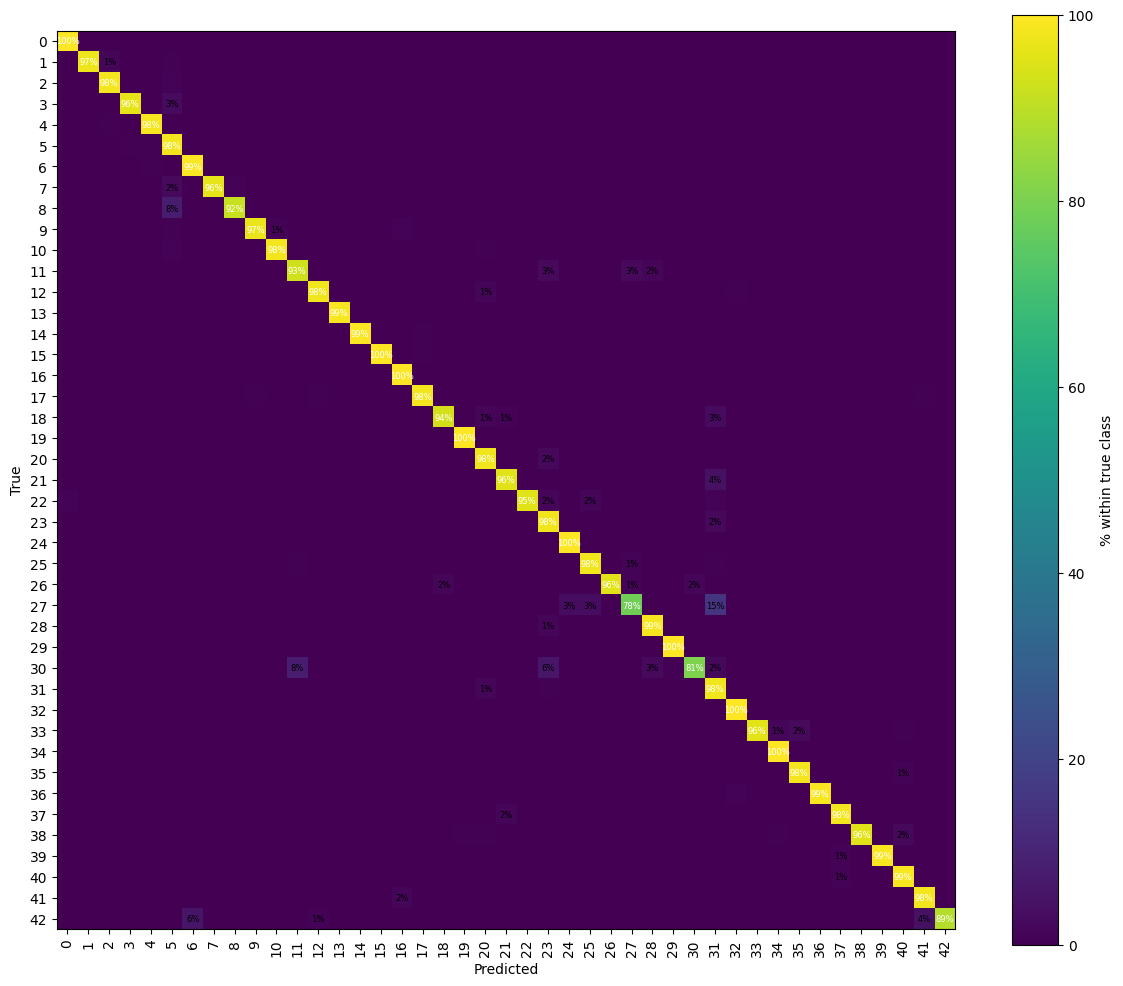

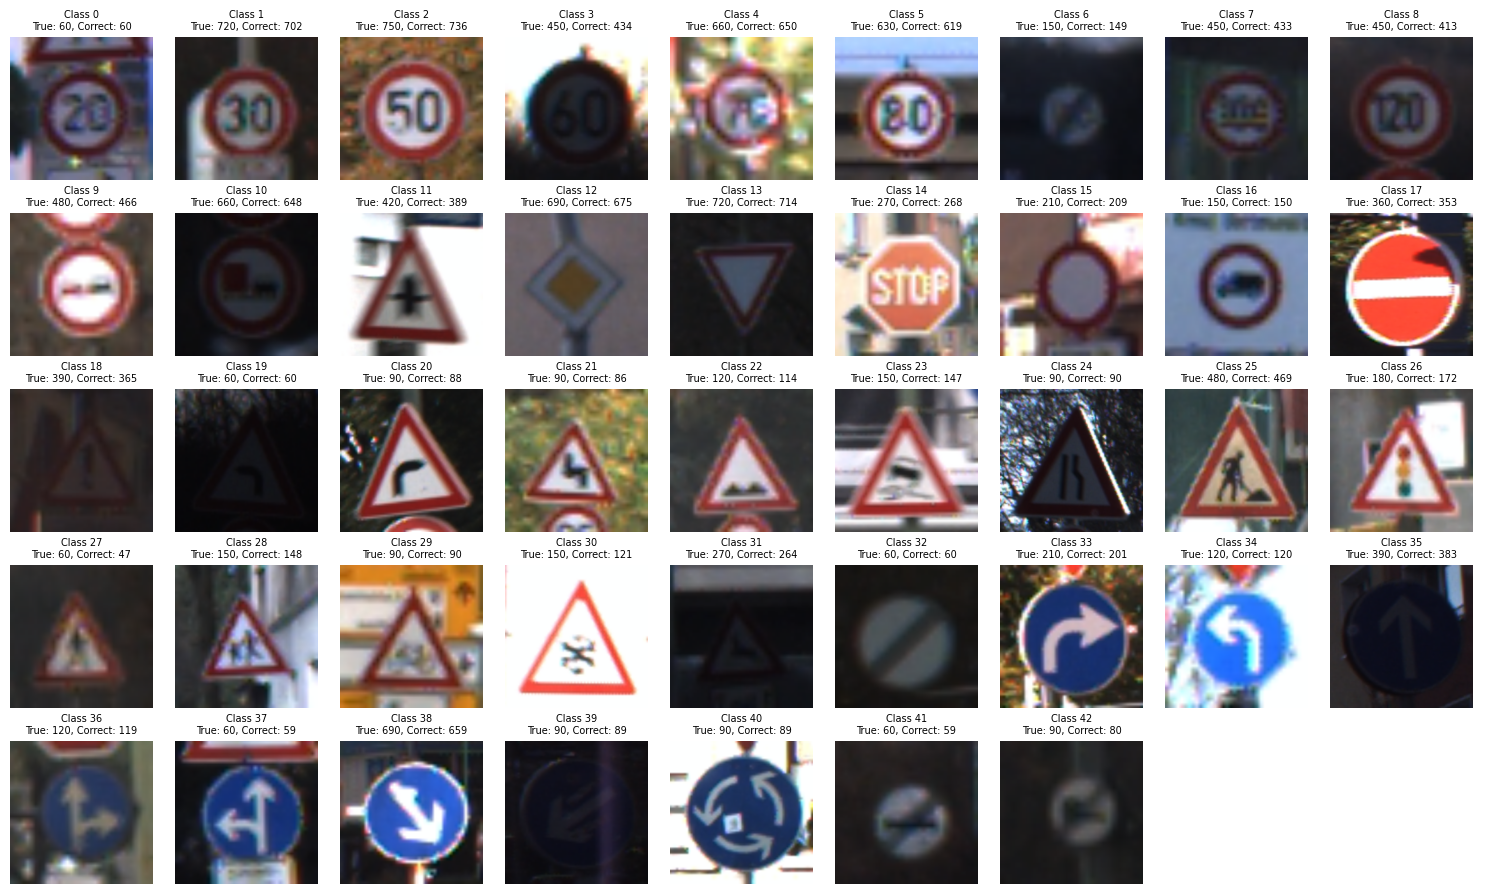

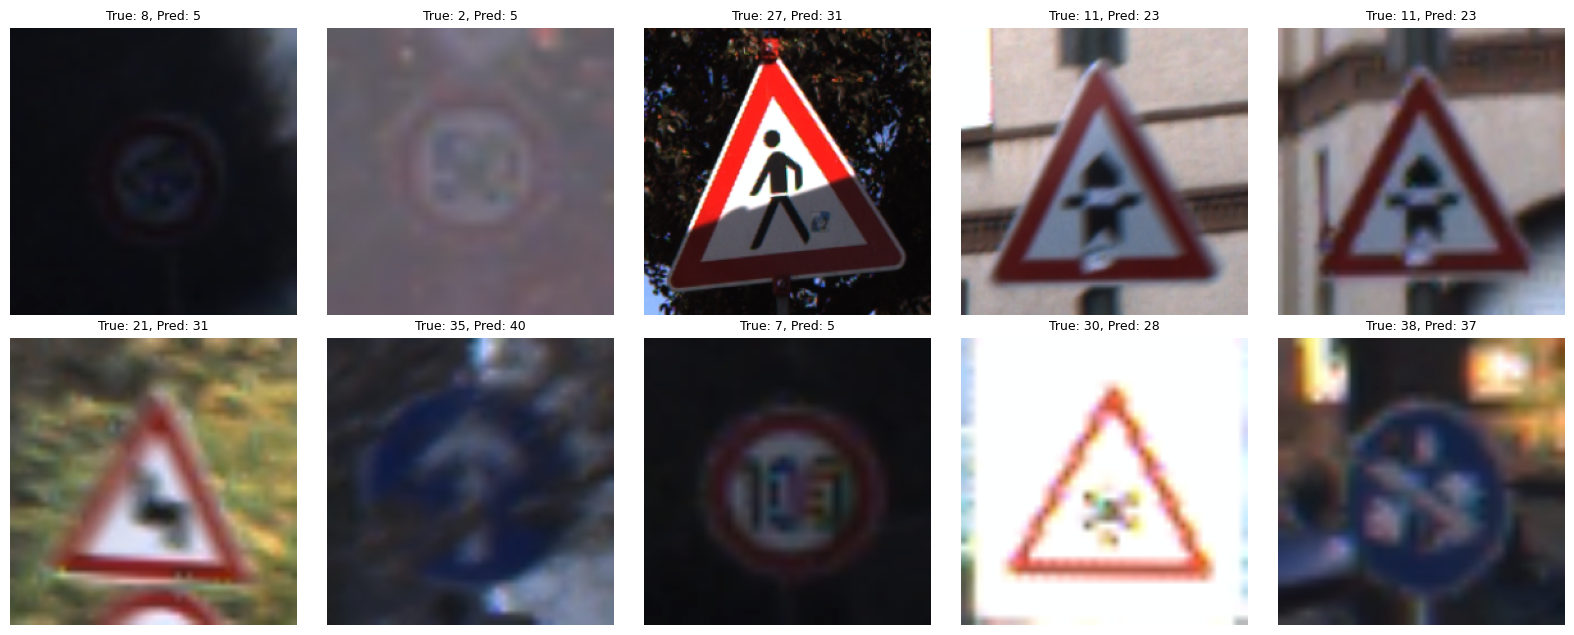

In [ ]:
# Evaluate Resnet (224×224 pipeline) and return metrics DF

resnet_metrics_df = test_loop(
    model_ctor=lambda: ResNet50Classifier(num_classes=NUM_CLASSES),
    ckpt_path="gtsrb_resnet.pth",   # path you saved in training
    test_loader=test_loader_resnet,       # 224×224 test loader
    test_dataset=test_resnet,            
    device=device,
    num_classes=NUM_CLASSES,
    mean=(0.485, 0.456, 0.406),     # ImsgrNet stats for un-normalization
    std=(0.229, 0.224, 0.225),
    normalize_cm=True,                 
    show_confusion=True,
    show_one_per_class=True,
    show_missed=True,
    max_missed=10
)

## **Combine the results of the models**

In [47]:
combined = pd.concat({
    "CNN":       cnn_metrics_df.set_index("Metric")["Score"],
    "MLP":       mlp_metrics_df.set_index("Metric")["Score"],
    "ResNet-50": resnet_metrics_df.set_index("Metric")["Score"],
}, axis=1)

summary_swapped = (combined * 100).round(2)
print(summary_swapped.to_string())

                     CNN    MLP  ResNet-50
Metric                                    
Accuracy           98.84  65.84      96.97
Precision (Macro)  98.32  64.90      95.14
Recall (Macro)     97.99  65.22      96.71
F1 (Macro)         97.98  63.50      95.79
Precision (Micro)  98.84  65.84      96.97
Recall (Micro)     98.84  65.84      96.97
F1 (Micro)         98.84  65.84      96.97


## **Results**

**Summary (Test Set, %):**

| Metric                |   CNN |   MLP | ResNet-50 |
|----------------------:|------:|------:|----------:|
| **Accuracy**          | 98.84 | 65.84 |     96.97 |
| **Precision (Macro)** | 98.32 | 64.90 |     95.14 |
| **Recall (Macro)**    | 97.99 | 65.22 |     96.71 |
| **F1 (Macro)**        | 97.98 | 63.50 |     95.79 |
| **Precision (Micro)** | 98.84 | 65.84 |     96.97 |
| **Recall (Micro)**    | 98.84 | 65.84 |     96.97 |
| **F1 (Micro)**        | 98.84 | 65.84 |     96.97 |

### Discussion & Evaluation

- **Overall performance.** The **custom CNN** achieves the best overall results (**98.84%** accuracy), slightly ahead of **ResNet-50** (**96.97%**), and far above the **MLP** baseline (**65.84%**).
- **Macro vs. Micro.** The near-equality of macro and micro scores for CNN/ResNet-50 suggests **balanced performance across classes** (not just on the frequent ones). This indicates that our **stratified split, targeted augmentation, and balanced sampling** helped mitigate class imbalance.
- **Why the MLP lags.** The MLP flattens images and **ignores spatial structure**, which is essential for fine-grained visual differences between traffic signs. This explains its large gap to CNN/ResNet.
- **CNN vs. ResNet-50.** Despite transfer learning, the custom CNN slightly outperforms ResNet-50. Likely reasons: (1) **partial fine-tuning** of ResNet-50 (only last block unfrozen), (2) the **domain gap** from ImageNet, and (3) our compact CNN being tailored to **64×64** inputs with stronger regularization for this task.

### Visual Evidence (Graphs & Plots)

- **Training curves** (loss/accuracy) show smooth convergence and no major overfitting for CNN/ResNet-50.
- **Confusion matrix (row-normalized %)** highlights a few systematic confusions between **visually similar signs** (e.g., adjacent speed limits, similar circular prohibitions).
- **Per-class gallery** (one image per class) with **true count vs. correct predictions** confirms solid coverage on rarer classes.
- **Error gallery** (10 misclassified samples) shows remaining failures under **poor lighting**, **motion blur**, or **high visual similarity**.

---

### Comparison with Prior Work

**Classical (pre-deep) approaches.** Earlier GTSRB systems using hand-crafted features (HOG/SIFT + SVM/Random Forest) typically reached the **mid-90%** range but struggled with viewpoint/illumination changes and required heavy feature engineering.

**Single CNNs.** With deep learning, single CNN models commonly report **~98–99%** on GTSRB, using small kernels, multi-stage conv blocks, and strong augmentation (rotations/affine jitter, color perturbations).  
Our **custom CNN at 98.84%** sits firmly within this tier, indicating that our pipeline (stratified split, targeted augmentation, balanced sampling) and compact architecture are well-matched to the dataset.

**Multi-scale / committee (ensemble) CNNs.** Ensembles or multi-column models often push results into the **high-99%** range, but at the cost of **substantially higher compute and memory** for both training and inference. We intentionally avoid ensembles to keep deployment practical.

**Transfer learning (ImageNet backbones).** Fine-tuned **ResNet-50** models commonly achieve **~95–99%**, depending on:
- How many layers are unfrozen (partial vs. full/gradual unfreezing)
- Input resolution and normalization
- Learning-rate schedules (cosine, warm-up, discriminative LRs)
- Training duration and augmentation strength

Our **ResNet-50 at 96.97%** is within expectation


## **Discussion, Analysis, and Future Work**

### Overall Performance
Our **custom CNN** achieves the strongest results on GTSRB (Accuracy **98.84%**, Macro-F1 **97.98%**), slightly ahead of **ResNet-50** (**96.97%**) and far above the **MLP** baseline (**65.84%**). Macro and micro scores are closely aligned for CNN/ResNet-50, indicating **balanced performance across frequent and rare classes** after stratified splitting and targeted augmentation.

The **confusion matrix** shows a small number of systematic errors between **visually similar classes** (e.g., adjacent speed-limit signs or similar circular prohibitions). The per-class gallery confirms good coverage on minority classes, while the error gallery points to challenging cases under **low light**, **motion blur**, **partial occlusion**, and **small object scale**.

---

### Strengths
- **High accuracy and class balance.** CNN/ResNet-50 maintain high macro scores, suggesting the model doesn’t collapse to frequent classes.
- **Efficient architecture.** The custom CNN with 64×64 inputs is **lightweight** and **deployment-friendly** while remaining competitive with single-model literature baselines.
- **Stable training.** Use of **ReduceLROnPlateau**, **AMP + GradScaler**, and **gradient clipping** led to smooth convergence without exploding gradients.
- **Clear diagnostics.** Plots (curves, confusion matrix, per-class counts, misclassified samples) provide actionable insight into failure modes.

---

### Weaknesses
- **ResNet-50 underutilization.** Partial fine-tuning (last block only) likely **under-leveraged** the backbone’s capacity; more layers need adapting to the traffic-sign domain.
- **Sensitivity to conditions.** Errors cluster in **low-light/blur/occluded** scenes and where signs occupy **few pixels**, indicating limited robustness to adverse capture conditions.
- **Fine-grained confusions.** Classes with **minor visual differences** (e.g., “26” vs “31”) remain the most confounded despite strong overall accuracy.

---

### Limitations
- **Single dataset.** Training and testing on GTSRB alone risks **dataset-specific bias**; real-world deployment faces wider variation in lighting, weather, cameras, and sign styles.
- **Classification-only pipeline.** We classify cropped signs; in practice, a full system needs **detection + tracking** before classification.
- **Limited tuning budget.** We used modest schedules and partial unfreezing for ResNet-50; stronger protocols could shift results.

---

### Future Work
- **Better fine-tuning for ResNet-50.**
  - Gradual/full **unfreezing** with **discriminative learning rates** and **cosine decay + warm-up**.
  - Longer schedules and early stopping based on macro-F1.
- **Stronger augmentation & regularization.**
  - **RandAugment/TrivialAugment**, **MixUp/CutMix**, label smoothing; modest **test-time augmentation (TTA)**.
  - Targeted robustness augments for **blur**, **glare**, **noise**, **small scale**; optional super-resolution for tiny signs.
- **Detection-first pipeline.**
  - Integrate a lightweight detector (e.g., YOLO-N/Tiny) to handle **small, partially occluded signs** prior to classification.

---

### Takeaways
- A **task-specific, compact CNN** offers an excellent **accuracy–efficiency** trade-off and is robust across classes.
- **ResNet-50** is close behind and likely to match/exceed CNN with better **fine-tuning and augmentation**.
- The remaining errors are largely **fine-grained confusions** and **adverse-condition artifacts**—addressable with improved augmentation, detection integration, and calibration.
